In [1]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time

tf.initialize(tf.cpu, "/O2 /fp:fast /openmp")

S = 512

def transpose(A):
    N, M = A.shape
    i, j = tf.indices([M, N])
    return A[j, i] * 1.0

def matmul():
    A = tf.input([-1, -1], tf.float32)
    B = tf.input([-1, -1], tf.float32)

    N, M = A.shape
    K = B.shape[1]
    
    C = tf.zeros([N, K])
    Bt = transpose(B)

    i, j, k = tf.indices([N, K, M])

    tf.scatterAdd(C[i, j], A[i, k] * Bt[j, k])

    return [C]

mmul = tf.program(matmul)

TensorFrost module loaded!
TensorProgram:
  Kernel count: 2
  Intermediate buffers: 6
  Lines of generated code: 132
  IR size: 81



In [2]:
Anp = np.random.rand(S, S).astype(np.float32)
Bnp = np.random.rand(S, S).astype(np.float32)

A = tf.memory(Anp)
B = tf.memory(Bnp)
C, = mmul(A, B)

Cnp = C.numpy

#compare to numpy
Cnp2 = Anp @ Bnp

print(Cnp)
print(Cnp2)
print(Cnp - Cnp2)


[[126.247345 125.10014  128.75008  ... 120.372246 123.31351  122.23771 ]
 [132.03331  132.51581  131.17192  ... 130.53722  128.13496  129.91032 ]
 [126.016464 129.32388  129.00166  ... 124.72703  121.316246 120.464165]
 ...
 [131.6895   135.3973   133.67635  ... 127.88709  126.33679  129.30595 ]
 [126.71903  129.30974  128.93031  ... 125.485855 128.68039  127.06998 ]
 [124.753174 126.58635  127.55995  ... 124.434135 127.42445  122.45565 ]]
[[126.24733  125.10021  128.75006  ... 120.372246 123.31352  122.23769 ]
 [132.0333   132.51575  131.17188  ... 130.53725  128.13501  129.91028 ]
 [126.016464 129.32388  129.00168  ... 124.72696  121.31622  120.464226]
 ...
 [131.68947  135.39734  133.67635  ... 127.887146 126.336685 129.30603 ]
 [126.719086 129.30972  128.93024  ... 125.485855 128.6804   127.0699  ]
 [124.753204 126.586365 127.55996  ... 124.43412  127.42447  122.45561 ]]
[[ 1.5258789e-05 -6.8664551e-05  1.5258789e-05 ...  0.0000000e+00
  -1.5258789e-05  1.5258789e-05]
 [ 1.5258789e

In [3]:
Anp = np.random.rand(S, S).astype(np.float32)
Bnp = np.random.rand(S, S).astype(np.float32)

A = tf.memory(Anp)
B = tf.memory(Bnp)

def TestFunc(f1, max_time):
    t0 = time.time()
    i = 0
    while time.time() - t0 < max_time:
        f1()
        i += 1
    return (time.time() - t0) / i

# Performance test
def TensorFrost():
    C, = mmul(A, B)

def Numpy():
    Cnp2 = Bnp @ Anp

np_time = TestFunc(Numpy, 10)
print("Numpy: ", np_time)

tf_time = TestFunc(TensorFrost, 10)
print("TensorFrost: ", tf_time)

print("TF/NP: ", tf_time / np_time)

Numpy:  0.0010671147260205949
TensorFrost:  0.06412178736466628
TF/NP:  60.08893495808506


In [4]:
# Test performance with different matrix sizes

def test_size(S):
    Anp = np.random.rand(S, S).astype(np.float32)
    Bnp = np.random.rand(S, S).astype(np.float32)

    A = tf.memory(Anp)
    B = tf.memory(Bnp)

    # Performance test
    def TensorFrost():
        C, = mmul(A, B)
    
    def Numpy():
        Cnp2 = Bnp @ Anp

    tf_time = TestFunc(TensorFrost, 1)
    np_time = TestFunc(Numpy, 1)

    return tf_time, np_time

sizes = [2**i for i in range(4, 12)]
tf_times = []
np_times = []

for S in sizes:
    tf_time, np_time = test_size(S)
    tf_times.append(tf_time)
    np_times.append(np_time)

    

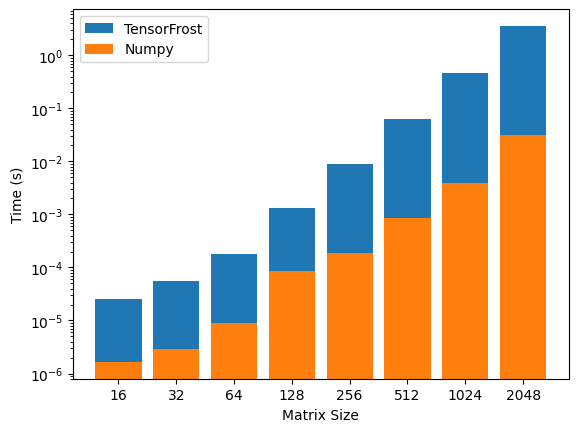

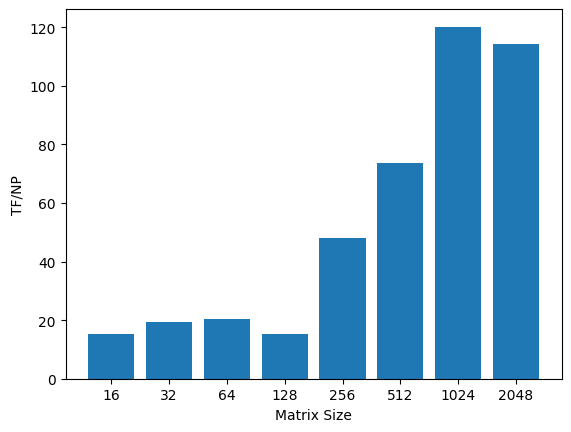

[2.550511407916566e-05, 5.5841004872444566e-05, 0.00018266413333642222, 0.0013046870008111, 0.009099995006214489, 0.06381238996982574, 0.4700006643931071, 3.597999095916748]
[1.6536923847956238e-06, 2.908225804780337e-06, 9.020630181224461e-06, 8.613270587904714e-05, 0.00018914327157880807, 0.0008650531405808604, 0.003910156898200512, 0.031468771398067474]


In [5]:
# Bar plot
size_str = [str(s) for s in sizes]
plt.bar(size_str, tf_times, label="TensorFrost")
plt.bar(size_str, np_times, label="Numpy")
plt.legend()
plt.xlabel("Matrix Size")
plt.ylabel("Time (s)")
plt.yscale("log")
plt.show()

# Bar plot with ratio
size_str = [str(s) for s in sizes]
plt.bar(size_str, [tf_times[i] / np_times[i] for i in range(len(sizes))])
plt.xlabel("Matrix Size")
plt.ylabel("TF/NP")
plt.show()


print(tf_times)
print(np_times)